## CNN classifier with transfer learning ResNet50

In [1]:
#Import the modules
import torch
from datasets import load_dataset
from PIL import Image
from torchvision import transforms, datasets, models
import os
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import torchvision
import random
import torch
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

/Users/mariannecivitardevol/Documents/EPFL/Masters/projet semestre1/semester_proj1/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Define the seed in order to keep reproducibility of the code

In [36]:
#make sure to keep reproducibility
def seed_all(seed):
    if not seed:
        seed = 10

    print("[ Using Seed : ", seed, " ]")

    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.cuda.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

def seed_worker(worker_id):
    worker_seed = torch.initial_seed() % 2**32
    np.random.seed(worker_seed)
    random.seed(worker_seed)

g = torch.Generator()
g.manual_seed(10)
seed_all(10)

[ Using Seed :  10  ]


### Define data transformations for data augmentation

In [37]:
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.RandomHorizontalFlip(),
        transforms.ColorJitter(brightness=(0.7,1.2), contrast=(0.7,1.2), saturation=(0), hue=(0)),
        transforms.ToTensor(), #convert all images data to tensor
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225]) #these are the RGB channels, mean and then std
    ]),
    'val': transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
    ]),
}

### View what the data augmentation does to the image

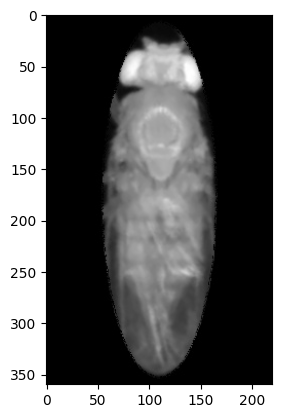

In [6]:
img1 = Image.open('dataset/train/back/fly1.jpg')
img2 = Image.open('dataset/train/back/fly2.jpg')
img3 = Image.open('dataset/train/stomach/fly1.jpg')
img4 = Image.open('dataset/train/stomach/fly2.jpg')
transform_test = transforms.ColorJitter(brightness=(1.2,1.2),contrast=(0),saturation=(0),hue=(0))
img = transform_test(img1)
plt.imshow(img)

In [38]:
# Define the data directory
data_dir = 'new_dataset'

# Create data loaders
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x), data_transforms[x]) for x in ['train', 'val']}
image_datasets

{'train': Dataset ImageFolder
     Number of datapoints: 1257
     Root location: new_dataset/train
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                RandomHorizontalFlip(p=0.5)
                ColorJitter(brightness=(0.7, 1.2), contrast=(0.7, 1.2), saturation=None, hue=None)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            ),
 'val': Dataset ImageFolder
     Number of datapoints: 314
     Root location: new_dataset/val
     StandardTransform
 Transform: Compose(
                Resize(size=(224, 224), interpolation=bilinear, max_size=None, antialias=True)
                ToTensor()
                Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
            )}

In [39]:
#load date into minibatches of size 4
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=4, shuffle=True, num_workers=0) for x in ['train','val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']} #check the number of images in each folder
print(dataset_sizes)

class_names = image_datasets['train'].classes
print(len(class_names))
class_names

{'train': 1257, 'val': 314}
2


['back', 'stomach']

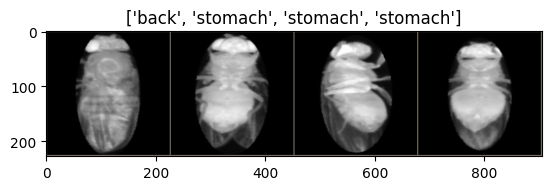

In [23]:
#View what the loaded data could look like
def imshow(inp, title=None):
    """Display image for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

### Perform training and fine tuning of the ResNet50 model

In [41]:
# Load the pre-trained ResNet-50 model
model = models.resnet50(pretrained=True)

# Load the saved model
model.fc = nn.Linear(model.fc.in_features, out_features=2)  # Adjust to match the original model's output units
model.train()

# Unfreeze all layers for fine-tuning
for param in model.parameters():
    param.requires_grad = True

# Define the loss function and optimizer
criterion = nn.CrossEntropyLoss() 

# Separate the parameters for the fully connected layer and the rest of the model
fc_params = model.fc.parameters()
base_params = [param for name, param in model.named_parameters() if "fc" not in name]

# Different learning rates for different layers
optimizer = optim.Adam([
    {'params': base_params, 'lr': 0.0001},
    {'params': fc_params, 'lr': 0.001}
])

# (Optional) Learning rate scheduler
scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=7, gamma=0.1)

# Move the model to the GPU if available
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Training loop
best_val_loss = float('inf')
best_model = None
num_epochs = 5
for epoch in range(num_epochs):
    print('epoch: ', epoch)
    for phase in ['train', 'val']:
        if phase == 'train':
            model.train()
        else:
            model.eval()

        running_loss = 0.0  # store the loss 
        running_corrects = 0  # store the correct predictions

        for inputs, labels in dataloaders[phase]:
            inputs = inputs.to(device)  # image
            labels = labels.to(device)  # class name

            optimizer.zero_grad()  # clear gradient from previous iteration

            with torch.set_grad_enabled(phase == 'train'):
                outputs = model(inputs)  # make predictions from input images
                _, preds = torch.max(outputs, 1)  # show the predictions
                loss = criterion(outputs, labels)  # compare predictions vs labels with cross entropy loss

                if phase == 'train':
                    loss.backward()
                    optimizer.step()

            running_loss += loss.item() * inputs.size(0)
            running_corrects += torch.sum(preds == labels.data)

        epoch_loss = running_loss / dataset_sizes[phase]
        epoch_acc = running_corrects.double() / dataset_sizes[phase]

        if phase == 'val':
            if running_loss < best_val_loss:
                best_val_loss = running_loss
                best_model = model.state_dict().copy()

        print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')
        if phase == 'train':
            scheduler.step()

print("Training complete!")


epoch:  0
train Loss: 0.1661 Acc: 0.9515
val Loss: 0.0019 Acc: 1.0000
epoch:  1
train Loss: 0.0096 Acc: 0.9992
val Loss: 0.0001 Acc: 1.0000
epoch:  2
train Loss: 0.0058 Acc: 0.9984
val Loss: 0.0009 Acc: 1.0000
epoch:  3
train Loss: 0.0009 Acc: 1.0000
val Loss: 0.0001 Acc: 1.0000
epoch:  4
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0000 Acc: 1.0000
epoch:  5
train Loss: 0.0002 Acc: 1.0000
val Loss: 0.0008 Acc: 1.0000
epoch:  6


KeyboardInterrupt: 

### Save the model for further use

In [42]:
torch.save(best_model, 'fly_CNN_model3_4_06Best.pth')

### Test the model accuracy with the test set

In [43]:
# Load the saved model
model = models.resnet50(pretrained=True)
model.fc = nn.Linear(model.fc.in_features, 2)  # Adjust to match the original model's output units
model.load_state_dict(torch.load('fly_CNN_model3_4_06Best.pth'))
model.eval()

# Define the image transformations
preprocess = transforms.Compose([
        transforms.Resize((224,224)),
        transforms.ToTensor(),
        transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

# Load the test dataset
test_dataset = datasets.ImageFolder('test_cnn', transform=preprocess)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=4, shuffle=False)

# Class names (make sure these match your training data)
class_names = ['back', 'stomach']

# Initialize lists to store predictions and true labels
all_preds = []
all_labels = []

# Perform inference and collect predictions and true labels
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, predicted = torch.max(outputs, 1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Calculate accuracy
correct = np.sum(np.array(all_preds) == np.array(all_labels))
total = len(all_labels)
accuracy = correct / total
print(f'Accuracy of the model on the test dataset: {accuracy * 100:.2f}%')

Accuracy of the model on the test dataset: 100.00%


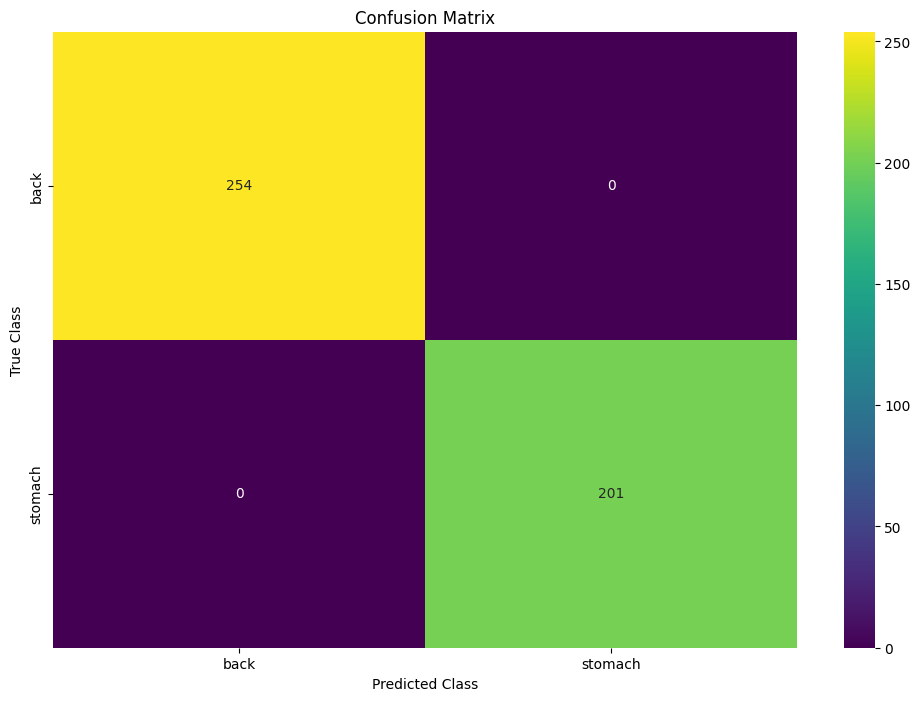

In [44]:
#Plot the confusion matrix
conf_matrix = confusion_matrix(all_labels, all_preds)

# Plot confusion matrix
plt.figure(figsize=(12, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names, cmap='viridis')
plt.title('Confusion Matrix')
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.show()